
Fais tes modifs.

git add .

git commit -m "mon message"

git push origin main (ça envoie sur ton GitHub).

puis faire le pull recuest

Et pour récupérer le travail : git pull upstream main.

In [315]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import time
import random as rd
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

pi = np.pi
def cos(x: float) ->float:
    return np.cos(x)
def sin(x: float) ->float:
    return np.sin(x)

# Le problème

$-\frac{d}{dx}(D(x)\frac{du}{dx})=f(x)$  $ 

$u(0)=u_0$

$u(1)=u_1$

In [316]:
def D(x:float) -> float:
    return 1 + sin(x)/2

In [317]:
def f(x:float) -> float:
    return pi*cos(x)*sin(2*pi*x)+4*pi*pi*(1 + sin(x)/2)*cos(2*pi*x)

## Les conditions aux limites 

In [318]:
u0 = 1
u1 = 1

## La solution Exact

In [319]:
def u_solution(x: float) -> float :
    return cos(2*pi*x)

# Discrétisation du problème

Posons le problème sous la forme AU = F

In [320]:
def A_constructor(N: int, D: Callable[[float], float]) -> np.ndarray :
    h = 1/N
    A = np.zeros((N-1, N-1), float)
    for i in range(N-1):
        for j in range(N-1):
            if i == j :
                A[i][j] = N*N*(D((i+1/2)*h) + D((i-1/2)*h))
            elif i + 1 == j :
                A[i][j] = -N*N*D((i+1/2)*h)
            elif i - 1 == j :
                A[i][j] = -N*N*D((i-1/2)*h)
            else :
                A[i][j] = 0
    return A


In [321]:
def F_constructor(N: int, f: Callable[[float], float], D: Callable[[float], float], u0: float, u1: float) -> np.ndarray :
    h = 1/N
    F = np.zeros((N-1), float)
    for i in range(N-1):
        F[i] = f((i+1)*h)
        if i == 0 :
            F[i] += N*N*D(1/(2*N))*u0
        elif i == N-2 :
            F[i] += N*N*D(((2*N-1)/(2*N)))*u1
    return F

* Puis on inverse A pour trouver U
* Et on essaye pour differente valeure de N
* Et enfin on trace l'erreur relative a la norme L2 comme fonction de N

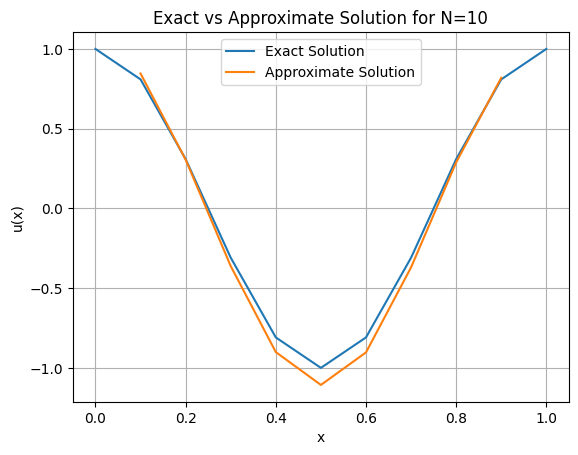

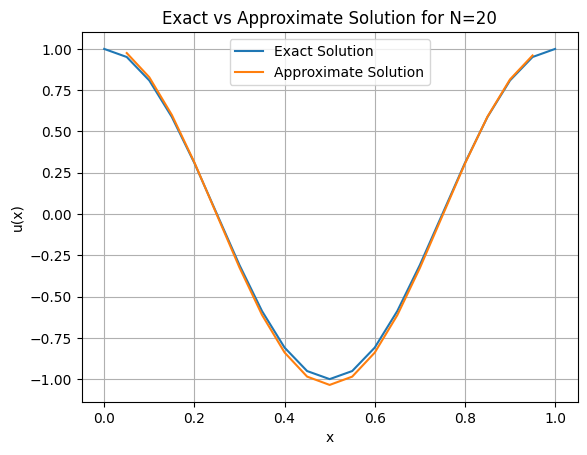

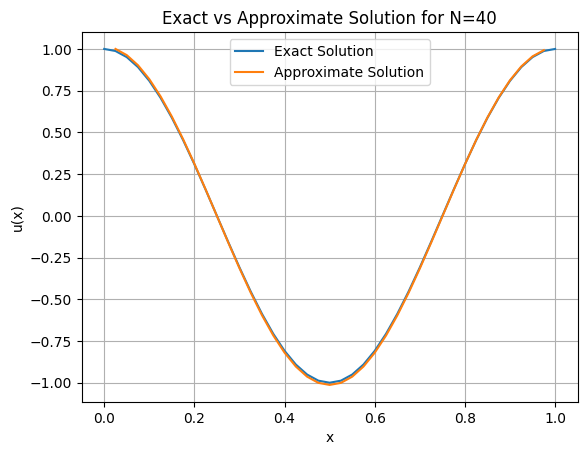

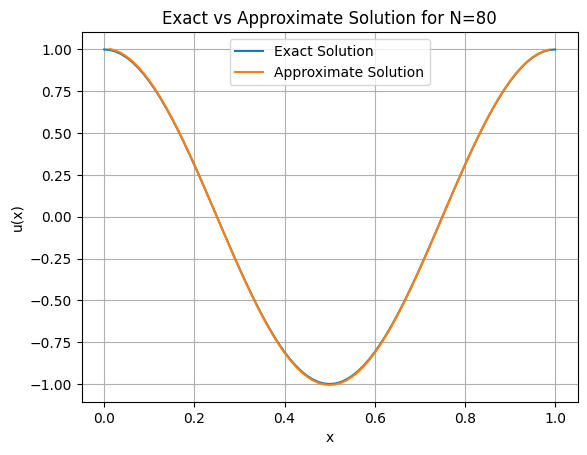

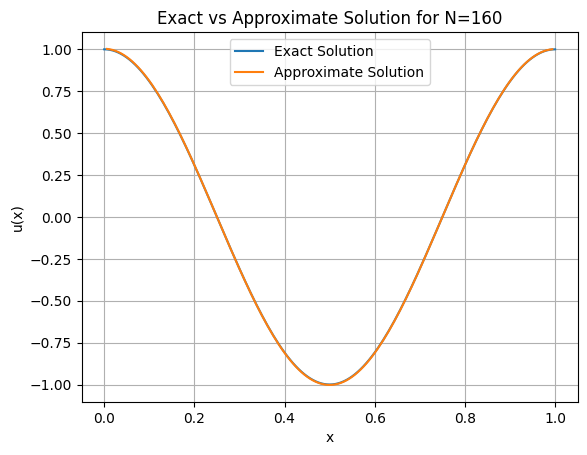

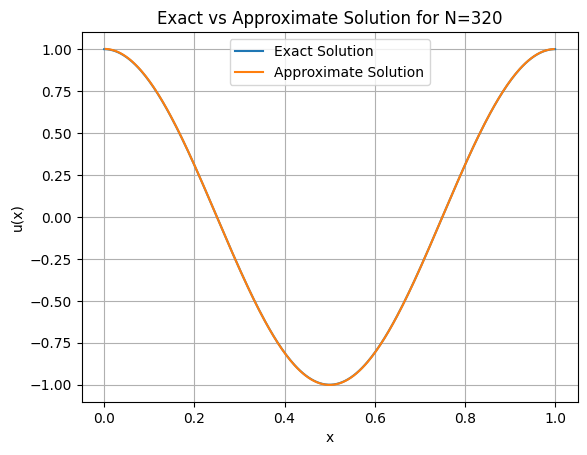

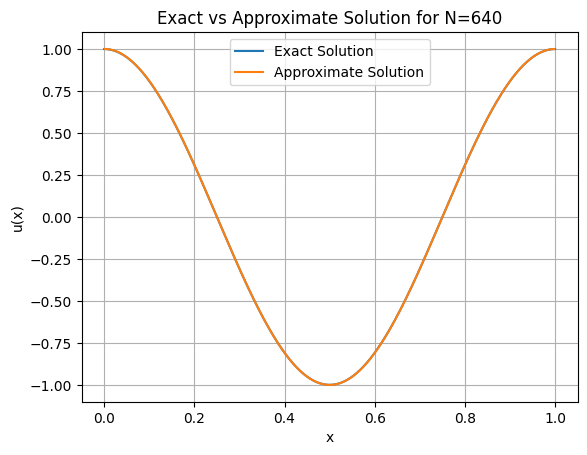

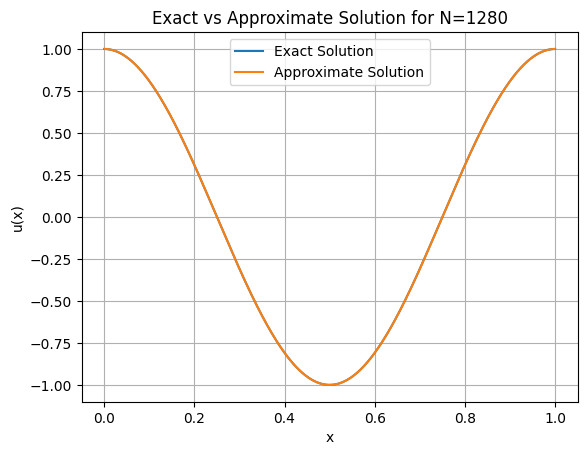

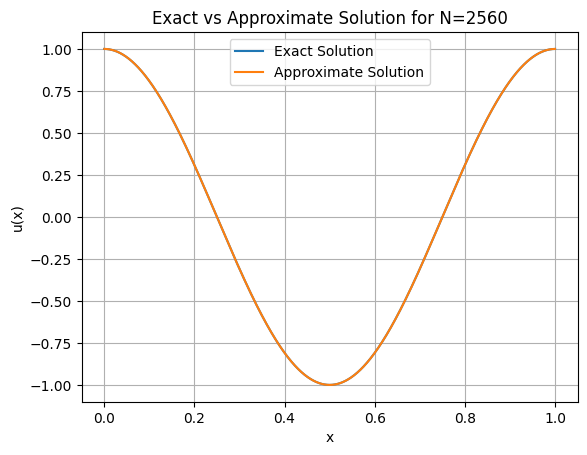

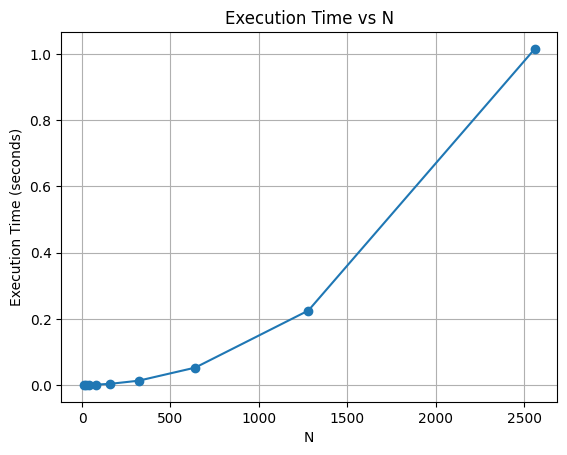

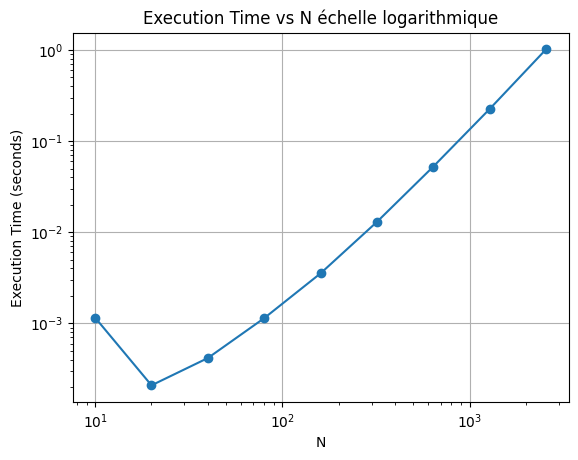

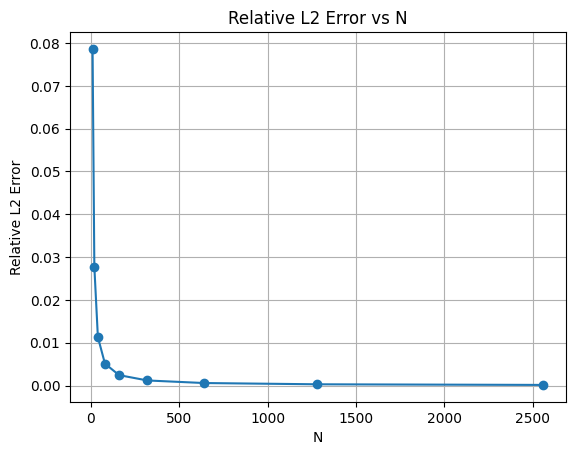

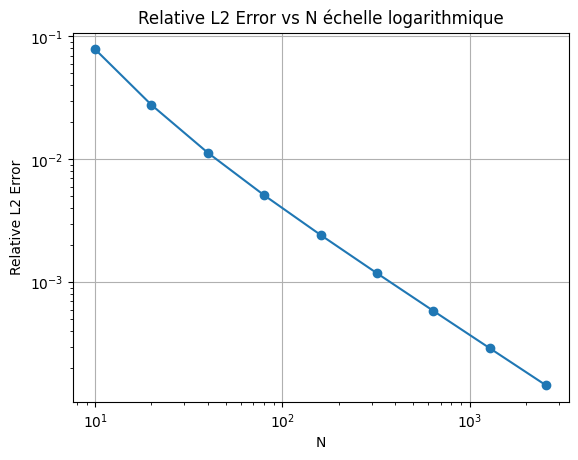

In [322]:
N_values = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
errors = []
duree = []
for N in N_values:
    start_time = time.time()
    A = np.array(A_constructor(N, D), dtype=float)
    F = np.array(F_constructor(N, f, D, u0, u1), dtype=float)
    u_approx = np.linalg.solve(A, F)
    x_values = [(i)/N for i in range(N+1)]
    u_exact = [u_solution(x) for x in x_values]
    error2 = np.sqrt(sum([(u_approx[i-1] - u_exact[i])**2 for i in range(1, N)]))/np.sqrt(sum([u_exact[i]**2 for i in range(N+1)]))
    errors.append(error2)
    duree.append(time.time() - start_time)
    plt.plot(x_values, u_exact, label='Exact Solution')
    plt.plot(x_values[1:N], u_approx, label='Approximate Solution')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(f'Exact vs Approximate Solution for N={N}')
    plt.legend()
    plt.grid()
    plt.show()
plt.plot(N_values, duree, marker='o')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs N')
plt.grid()
plt.show()
plt.loglog(N_values, duree, marker='o')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs N échelle logarithmique')
plt.grid()
plt.show()
plt.plot(N_values, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs N')
plt.grid()
plt.show()
plt.loglog(N_values, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs N échelle logarithmique')
plt.grid()
plt.show()


# Deuxième cas test (maintenant paramétrique)

$D_{\mu}= 1 + \mu_D$

$f_{\mu}(x) = \mu_1 sin(\pi x) + \mu_2 sin(2\pi x)$

$u(0)= u_0 ~~~ u(1)=u_1 ~~~ x \in (0, 1)$


In [323]:
u0 = 0
u1 = 0

In [324]:
def D_mu(x: float, muD: float) -> float:
    return 1 + muD
def D0(x: float) -> float:
    return D_mu(x, 0)

In [325]:
def f_mu(x: float, mu1: float, mu2: float) -> float:
    return mu1*sin(pi*x) + mu2*sin(2*pi*x)
def f1(x: float) -> float:
    return f_mu(x, 1, 0)
def f2(x: float) -> float:
    return f_mu(x, 0, 1)

In [326]:
def u_exact(x: float, mu1: float, mu2: float, muD: float) -> float:
    return (mu1*sin(pi*x) + mu2/4*sin(2*pi*x))/(pi*pi*(1 + muD))

In [347]:
N=320
A0 = A_constructor(N, D0)
F1 = F_constructor(N, f1, D0, u0, u1)
F2 = F_constructor(N, f2, D0, u0, u1)


In [328]:
def get_smart_mu_list(Ns: int):
    """
    Renvoie une liste de Ns triplets (muD, mu1, mu2) en priorisant
    les coins de l'hypercube des paramètres pour maximiser l'information.
    """
    
    # --- 1. Définition des bornes ---
    # muD dans [0.1, 1.0]
    # mu1 dans [1.0, 10.0]
    # mu2 dans [1.0, 10.0]
    
    # --- 2. La liste "Académique" des 8 coins (triée par importance) ---
    corners = [
        (0.1, 1.0, 1.0),    # 1. Tout au MIN (Point de départ)
        (0.1, 10.0, 1.0),   # 3. Force 1 Max, le reste Min
        (1.0, 10.0, 10.0),  # 2. Tout au MAX (Opposé diagonal -> Info max)
        (1.0, 1.0, 10.0),   # 4. Force 2 Max + Diff Max (Opposé du 3) 
        (0.1, 1.0, 10.0),   # 5. Force 2 Max, le reste Min
        (1.0, 10.0, 1.0),   # 6. Force 1 Max + Diff Max (Opposé du 5)
        (1.0, 1.0, 1.0),    # 7. Juste Diff Max
        (0.1, 10.0, 10.0),  # 8. Force 1 & 2 Max (Diff Min)
    ]
    return corners[:Ns]

In [351]:
def U_snapshot_constructor(N: int, N_s: int, A0: np.ndarray, F1: np.ndarray, F2: np.ndarray) -> np.ndarray:
    U_snapshot = np.zeros((N-1, N_s), float)
    i=0
    for muD, mu1, mu2 in get_smart_mu_list(N_s):
        A = (1 + muD)*A0
        F = mu1*F1 + mu2*F2
        u_approx = np.linalg.solve(A, F)
        U_snapshot[:, i] = u_approx
        i += 1
    return U_snapshot
    
N_s=8
U_snapshot = U_snapshot_constructor(N, N_s, A0, F1, F2)


# Décomposition en SVD

number of singular values: 8
V shape: (319, 319)
S shape: (8,)
U shape: (8, 8)
Singular values: [1.91181462e+01 3.73997152e+00 5.89577823e-14 1.17663635e-14
 3.05526547e-15 1.61711795e-15 3.10519357e-16 1.32592903e-16]


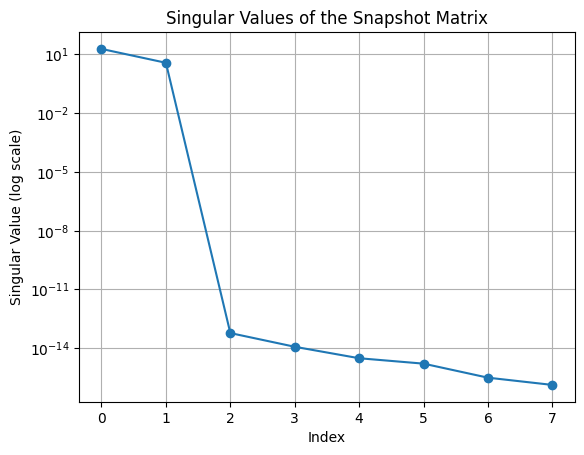

In [352]:
(V, S, U) = np.linalg.svd(U_snapshot)
print("number of singular values:", len(S))
print("V shape:", V.shape)
print("S shape:", S.shape)
print("U shape:", U.shape)
print("Singular values:", S)
plt.semilogy(S, marker='o')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Values of the Snapshot Matrix')
plt.grid()
plt.show()

ps: $10^{-15}$ étant la précision machine seul les 2 premières valeurs ont un sens.

# Un premier test


In [331]:
muD = 0.5
mu1 = 2
mu2 = 10

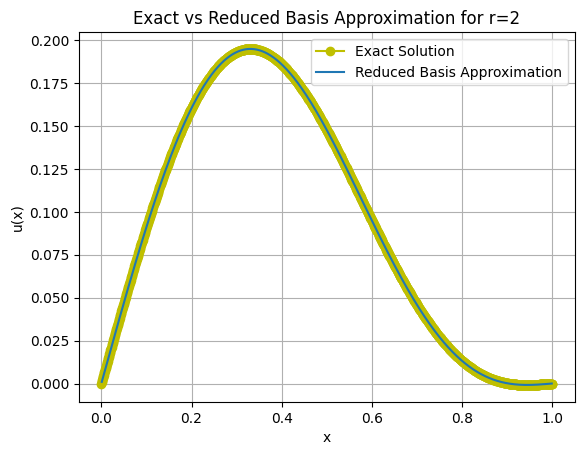

In [355]:
def approche_reduction(r: int, V: np.ndarray, A0: np.ndarray, F1: np.ndarray, F2: np.ndarray, muD: float, mu1: float, mu2: float) -> tuple[np.ndarray, np.ndarray]:
    V_r = V[:, :r]
    A_r = V_r.T @ A0 @ V_r
    A_r_inv = np.linalg.inv(A_r)
    F_r1 = A_r_inv @ V_r.T @ F1
    F_r2 = A_r_inv @ V_r.T @ F2
    u_r = 1/(1+muD)*(mu1*F_r1 + mu2*F_r2)
    u_approx = V_r @ u_r
    return u_r, u_approx
r = 2
u_r, u_approx = approche_reduction(r, V, A0, F1, F2, muD, mu1, mu2)
x_values = [(i)/N for i in range(N+1)]
x_values_sol_exact = [(i)/1280 for i in range(1281)]
u_exact_values = [u_exact(x, mu1, mu2, muD) for x in x_values_sol_exact]
plt.plot(x_values_sol_exact, u_exact_values, 'o-y', label='Exact Solution')
plt.plot(x_values[1:N], u_approx, label='Reduced Basis Approximation')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'Exact vs Reduced Basis Approximation for r={r}')
plt.legend()
plt.grid()
plt.show()


# Qui est V

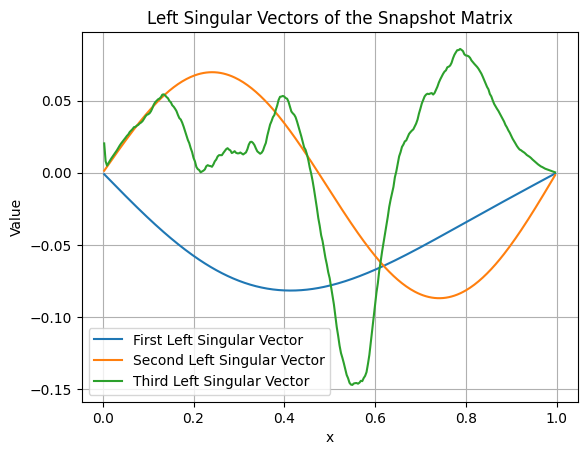

In [333]:
V1 = V[:, :1]
V2 = V[:, 1:2]
V3 = V[:, 2:3]
plt.plot(x_values[1:N], V1, label='First Left Singular Vector')
plt.plot(x_values[1:N], V2, label='Second Left Singular Vector')
plt.plot(x_values[1:N], V3, label='Third Left Singular Vector')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Left Singular Vectors of the Snapshot Matrix')
plt.legend()
plt.grid()
plt.show()

A noter que la troisième fonction n'a enfaite peu de sens puisque associé à une valeur singulière de l'ordre de grandeur de la précision machine.

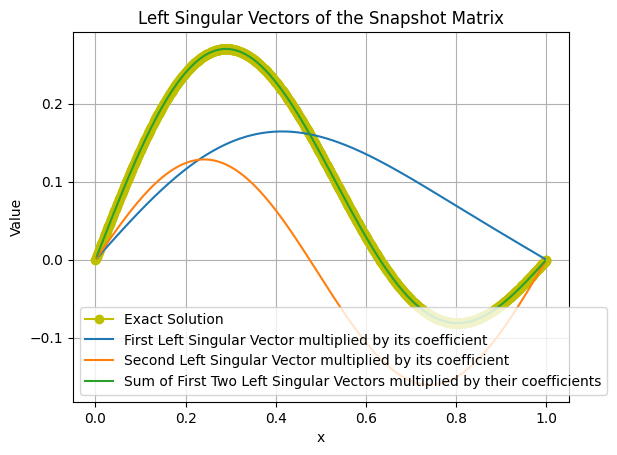

In [ ]:
V1_coef = u_r[0]*V[:, :1]
V2_coef = u_r[1]*V[:, 1:2]
Somme = V1_coef + V2_coef
plt.plot(x_values_sol_exact, u_exact_values,'o-y' ,label='Exact Solution')
plt.plot(x_values[1:N], V1_coef, label='First Left Singular Vector multiplied by its coefficient')
plt.plot(x_values[1:N], V2_coef, label='Second Left Singular Vector multiplied by its coefficient')
plt.plot(x_values[1:N], Somme, label='Sum of First Two Left Singular Vectors multiplied by their coefficients')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Left Singular Vectors of the Snapshot Matrix')
plt.legend()
plt.grid()
plt.show()

V est enfaite "comme" dans un developpement en serie une base de fonction permettant de reconstruire la vrai solution

$ u_r $ est alors la projection orthobonale de la solution sur cette base finie de fonction 

Pour tester interessons nous aux cas ou V contiendrait une base orthogonal des discrétisations entre 0 et 1 des polynomes de degres $deg_{max}$

(319, 3)


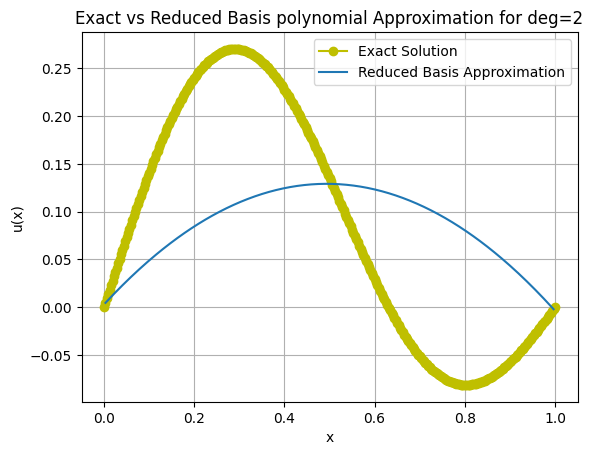

(319, 4)


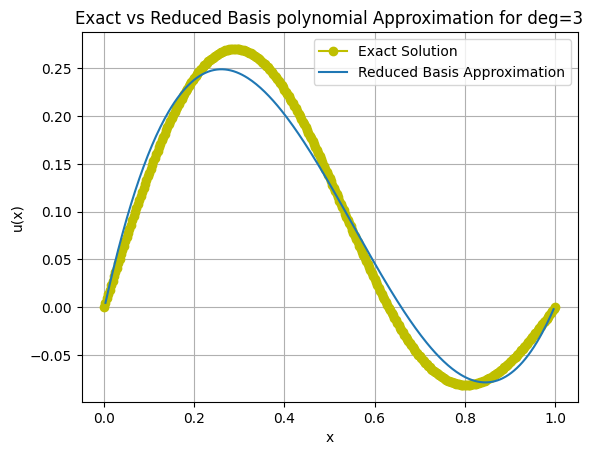

(319, 5)


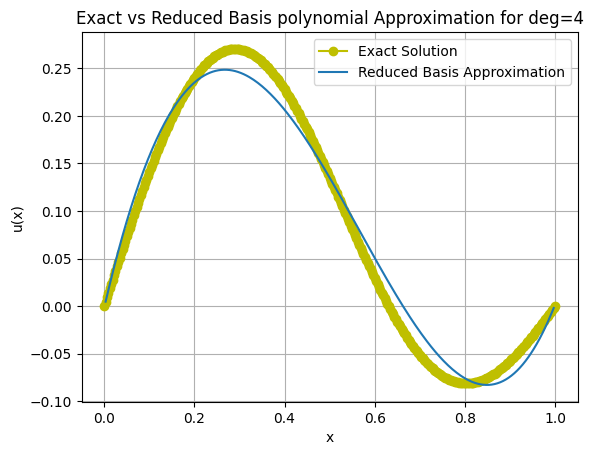

(319, 6)


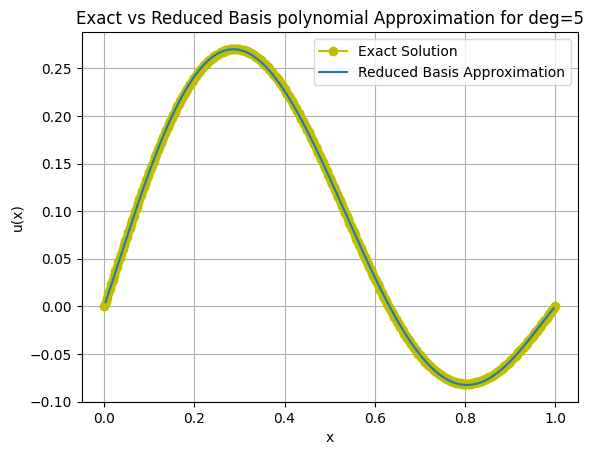

In [335]:
for deg_max in range(2, 6):
    x = np.linspace(0, 1, N-1).reshape(-1, 1) # Vecteur colonne de 0 à 1

# 1. Création de la base de Vandermonde classique (1, x, x^2, x^3, x^4)
    V_polynome = x ** np.arange(deg_max + 1)

# 2. Orthonormalisation via la décomposition QR
# La décomposition QR transforme une matrice en une matrice Q (orthonormale) 
# et R (triangulaire supérieure).
    Q, R = np.linalg.qr(V_polynome)

# 3. Normalisation finale
# QR assure l'orthogonalité par rapport au produit scalaire discret (somme de produits).
# On multiplie par racine de N pour que la norme soit cohérente avec l'intervalle.
    V_ortho = Q * np.sqrt(len(x))

    print(V_ortho.shape) # Devrait être (N-1, 5)

    A_r_polynome= V_ortho.T @ A0 @ V_ortho
    A_r_polynome_inv = np.linalg.inv(A_r_polynome)
    F_r1 = A_r_polynome_inv @ V_ortho.T @ F1
    F_r2 = A_r_polynome_inv @ V_ortho.T @ F2
    u_r_polynome = 1/(1+muD)*(mu1*F_r1 + mu2*F_r2)
    u_approx_polynome = V_ortho @ u_r_polynome
    x_values = [(i)/N for i in range(N+1)]
    x_values_sol_exact = [(i)/N for i in range(N+1)]
    u_exact_values = [u_exact(x, mu1, mu2, muD) for x in x_values_sol_exact]
    plt.plot(x_values_sol_exact, u_exact_values, 'o-y', label='Exact Solution')
    plt.plot(x_values[1:N], u_approx_polynome, label='Reduced Basis Approximation')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(f'Exact vs Reduced Basis polynomial Approximation for deg={deg_max}')
    plt.legend()
    plt.grid()
    plt.show()


## TEST ET ERREUR


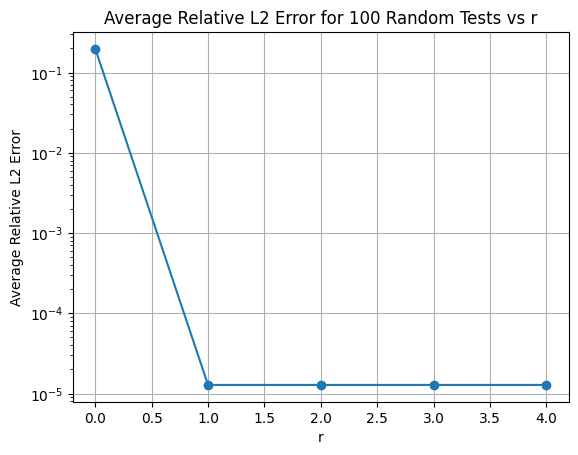

In [336]:
N_test = 100
Liste_mu = [(0.1 + 0.9*rd.random(), 1 + 9*rd.random(), 1 + 9*rd.random()) for _ in range(N_test)]
errors_average_r = []
for r in range(1, 6):
    errors_test = []
    for muD, mu1, mu2 in Liste_mu:
        u_r, u_approx = approche_reduction(r, V, A0, F1, F2, muD, mu1, mu2)
        x_values = [(i)/N for i in range(N+1)]
        u_exact_values = [u_exact(x, mu1, mu2, muD) for x in x_values]
        error2 = np.sqrt(sum([(u_approx[i-1] - u_exact_values[i])**2 for i in range(1, N)]))/np.sqrt(sum([u_exact_values[i]**2 for i in range(N+1)]))
        errors_test.append(error2)
    errors_average_r.append(np.mean(errors_test))
plt.semilogy(errors_average_r, marker='o')
plt.xlabel('r')
plt.ylabel('Average Relative L2 Error')
plt.title('Average Relative L2 Error for 100 Random Tests vs r')
plt.grid()
plt.show()

## En réalité l'erreur est une fonction de 3 paramètres (N, $N_s$, r)

In [353]:
N_test = 100
r_coords = np.arange(0, 6)   
Ns_coords = np.arange(0, 6) 
Liste_mu = [(0.1 + 0.9*rd.random(), 1 + 9*rd.random(), 1 + 9*rd.random()) for _ in range(N_test)]
errors_average_r_Ns_N = []
for N in [10, 100, 1000] :
    A0 = A_constructor(N, D0)
    F1 = F_constructor(N, f1, D0, u0, u1)
    F2 = F_constructor(N, f2, D0, u0, u1)
    errors_average_r_Ns = np.zeros((len(Ns_coords), len(r_coords)), float)
    for N_s in Ns_coords:
        U_snapshot = U_snapshot_constructor(N, N_s, A0, F1, F2)
        (V, S, U) = np.linalg.svd(U_snapshot)
        for r in r_coords:
            errors_test = []
            for muD, mu1, mu2 in Liste_mu:
                u_r, u_approx = approche_reduction(r, V, A0, F1, F2, muD, mu1, mu2)
                x_values = [(i)/N for i in range(N+1)]
                u_exact_values = [u_exact(x, mu1, mu2, muD) for x in x_values]
                error2 = np.sqrt(sum([(u_approx[i-1] - u_exact_values[i])**2 for i in range(1, N)]))/np.sqrt(sum([u_exact_values[i]**2 for i in range(N+1)]))
                errors_test.append(error2)
            errors_average_r_Ns[N_s][r] = np.mean(errors_test)
    errors_average_r_Ns_N.append(errors_average_r_Ns)
        


    




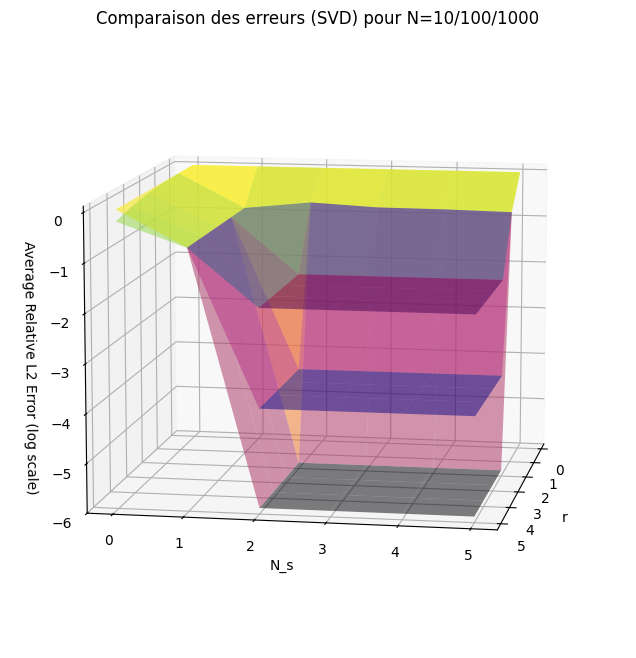

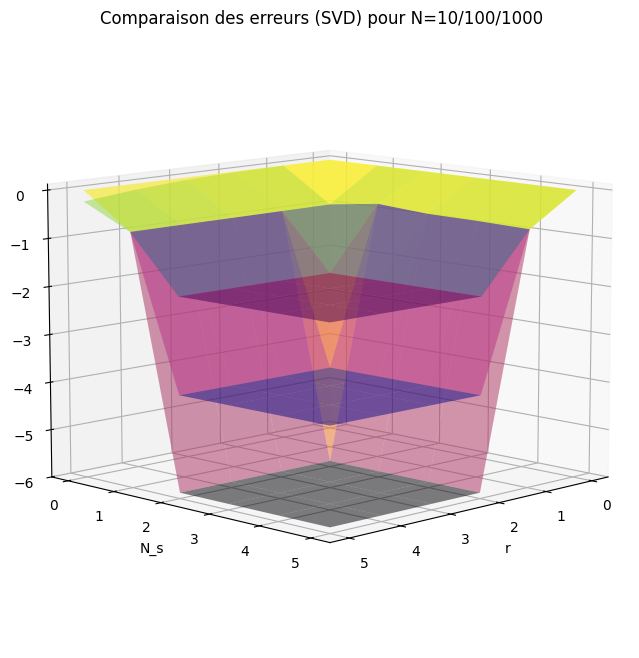

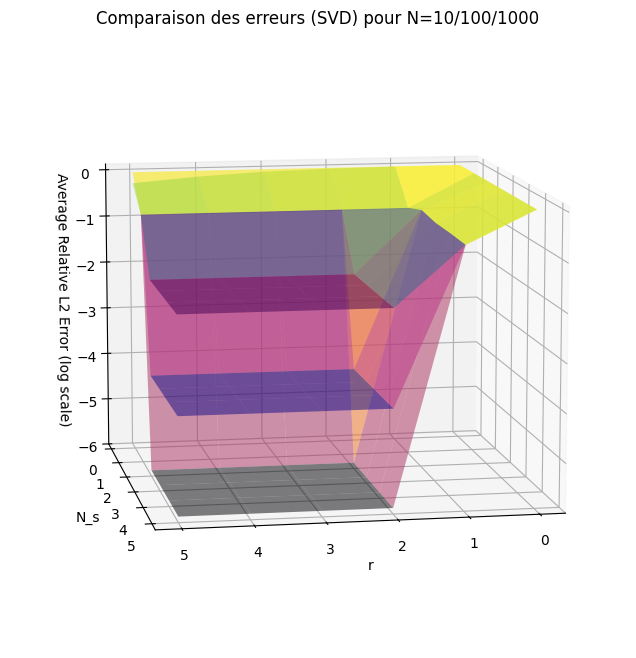

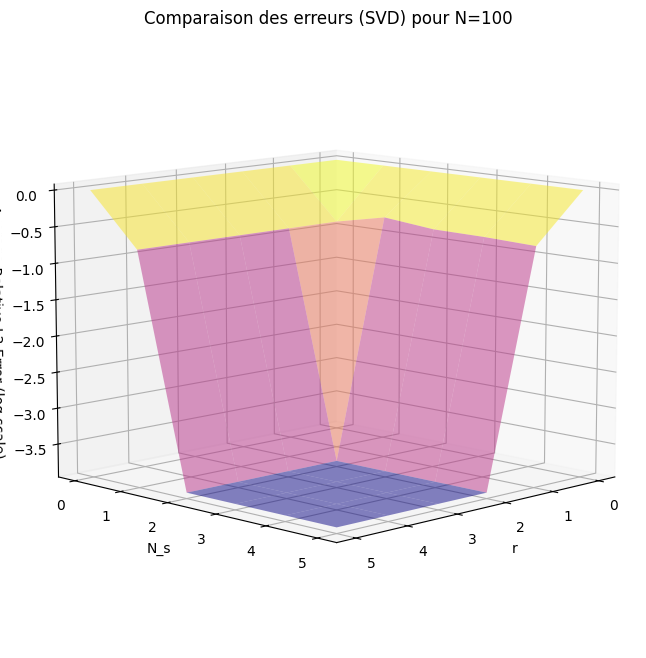

In [354]:
X, Y = np.meshgrid(r_coords, Ns_coords)
Z1, Z2, Z3 = errors_average_r_Ns_N[0], errors_average_r_Ns_N[1], errors_average_r_Ns_N[2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# On utilise des cmaps différentes ou des couleurs fixes pour les distinguer
# alpha=0.5 rend la surface semi-transparente
ax.plot_surface(X, Y, np.log10(Z1), cmap='viridis', alpha=0.5, label='N1')
ax.plot_surface(X, Y, np.log10(Z2), cmap='plasma', alpha=0.5, label='N2')
ax.plot_surface(X, Y, np.log10(Z3), cmap='inferno', alpha=0.5, label='N3')


ax.view_init(elev=10, azim=10)

ax.set_xlabel('r')
ax.set_ylabel('N_s')
ax.set_zlabel('Average Relative L2 Error (log scale)')
ax.set_title('Comparaison des erreurs (SVD) pour N=10/100/1000')

plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# On utilise des cmaps différentes ou des couleurs fixes pour les distinguer
# alpha=0.5 rend la surface semi-transparente
ax.plot_surface(X, Y, np.log10(Z1), cmap='viridis', alpha=0.5, label='N1')
ax.plot_surface(X, Y, np.log10(Z2), cmap='plasma', alpha=0.5, label='N2')
ax.plot_surface(X, Y, np.log10(Z3), cmap='inferno', alpha=0.5, label='N3')



ax.view_init(elev=10, azim=45)

ax.set_xlabel('r')
ax.set_ylabel('N_s')
ax.set_zlabel('Average Relative L2 Error (log scale)')
ax.set_title('Comparaison des erreurs (SVD) pour N=10/100/1000')

plt.show()



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# On utilise des cmaps différentes ou des couleurs fixes pour les distinguer
# alpha=0.5 rend la surface semi-transparente
ax.plot_surface(X, Y, np.log10(Z1), cmap='viridis', alpha=0.5, label='N1')
ax.plot_surface(X, Y, np.log10(Z2), cmap='plasma', alpha=0.5, label='N2')
ax.plot_surface(X, Y, np.log10(Z3), cmap='inferno', alpha=0.5, label='N3')



ax.view_init(elev=10, azim=80)

ax.set_xlabel('r')
ax.set_ylabel('N_s')
ax.set_zlabel('Average Relative L2 Error (log scale)')
ax.set_title('Comparaison des erreurs (SVD) pour N=10/100/1000')

plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# On utilise des cmaps différentes ou des couleurs fixes pour les distinguer
# alpha=0.5 rend la surface semi-transparente
ax.plot_surface(X, Y, np.log10(Z2), cmap='plasma', alpha=0.5, label='N2')



ax.view_init(elev=10, azim=45)

ax.set_xlabel('r')
ax.set_ylabel('N_s')
ax.set_zlabel('Average Relative L2 Error (log scale)')
ax.set_title('Comparaison des erreurs (SVD) pour N=100')

plt.show()

En faite il faut juste prendre $N_s$ de sorte à avoir toutes les directions engendré par le vecteur qui est linaire en (mu1, mu2). Donc ici Ns = 2 sufit. Mais attention de ne pas générer uniquement des vecteurs colinaires